<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Softmax-Regression:" data-toc-modified-id="Softmax-Regression:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Softmax Regression:</a></span></li><li><span><a href="#Comparing-Machine-Learning-Techniques:" data-toc-modified-id="Comparing-Machine-Learning-Techniques:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Comparing Machine Learning Techniques:</a></span></li><li><span><a href="#Tuning:-Batch-Size-and-Number-of-Epochs-for-Neural-Networks" data-toc-modified-id="Tuning:-Batch-Size-and-Number-of-Epochs-for-Neural-Networks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tuning: Batch Size and Number of Epochs for Neural Networks</a></span></li><li><span><a href="#Tune-Training-Optimization-Algorithm:" data-toc-modified-id="Tune-Training-Optimization-Algorithm:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Tune Training Optimization Algorithm:</a></span></li><li><span><a href="#Tune-Learning-Rate,-Momentum:" data-toc-modified-id="Tune-Learning-Rate,-Momentum:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tune Learning Rate, Momentum:</a></span></li><li><span><a href="#Tune-Weight-Initialization:" data-toc-modified-id="Tune-Weight-Initialization:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Tune Weight Initialization:</a></span></li><li><span><a href="#Tune-Droprate-Regularization:" data-toc-modified-id="Tune-Droprate-Regularization:-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Tune Droprate Regularization:</a></span></li><li><span><a href="#Model-1:" data-toc-modified-id="Model-1:-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Model 1:</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Make-these-into-functions-for-plotting:" data-toc-modified-id="Make-these-into-functions-for-plotting:-8.0.0.1"><span class="toc-item-num">8.0.0.1&nbsp;&nbsp;</span>Make these into functions for plotting:</a></span></li></ul></li></ul></li></ul></li></ul></div>

Data Exploration / Model Tinkering


Admission Type:

Provided data dictionary indicates that integers 0-9 are used to represent codes. Based on research we will draw the following conclusions:

Personal physician referral (or self-referral)
This hospital's clinic referral
HMO referral
Transfer from another hospital
Transfer from nursing home
Transfer from another healthcare facility
This hospital's Emergency Room
Court or law enforcement
Information not available

In [1]:
%store -r X
%store -r y
%store -r y_two

In [192]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models, layers, optimizers, regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from keras.layers import Dropout, Dense, Activation
from keras.constraints import maxnorm
from keras.optimizers import SGD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense, Dropout

import matplotlib.gridspec as gridspec
import random

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score

from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

plt.style.use('ggplot')
plt.xkcd();
%matplotlib inline

In [188]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # Check if Normalization Option is Set to True. 
    # If so, normalize the raw confusion matrix before visualizing
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without Normalization')
        
    # Print CNF Matrix
    print(cm)
    
    # Create the Matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # Add Title, Axis Labels:
    # . classes = class_names
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add cell labels:
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()  

In [3]:
display(X.head())
display(y.head())

,gender,age,admission_type_id,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,discharge_home,log_add1_time_in_hospital,metformin_Down,metformin_No,metformin_Steady,metformin_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up
0,1,0,6,41,0,1,0,0,0,1,...,0,0.693147,0,1,0,0,0,1,0,0
1,1,1,1,59,0,18,0,0,0,9,...,1,1.386294,0,1,0,0,0,0,0,1
2,1,2,1,11,5,13,2,0,1,6,...,1,1.098612,0,1,0,0,0,1,0,0
3,0,3,1,44,1,16,0,0,0,7,...,1,1.098612,0,1,0,0,0,0,0,1
4,0,4,1,51,0,8,0,0,0,5,...,1,0.693147,0,1,0,0,0,0,1,0


,<30,>30,NO
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1


In [4]:
X.columns

Index(['gender', 'age', 'admission_type_id', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'change',
       'diabetesMed', 'ad_id_1', 'ad_id_2', 'ad_id_3', 'discharge_home',
       'log_add1_time_in_hospital', 'metformin_Down', 'metformin_No',
       'metformin_Steady', 'metformin_Up', 'insulin_Down', 'insulin_No',
       'insulin_Steady', 'insulin_Up'],
      dtype='object')

Text(0.5, 1.0, 'Multicollinearity')

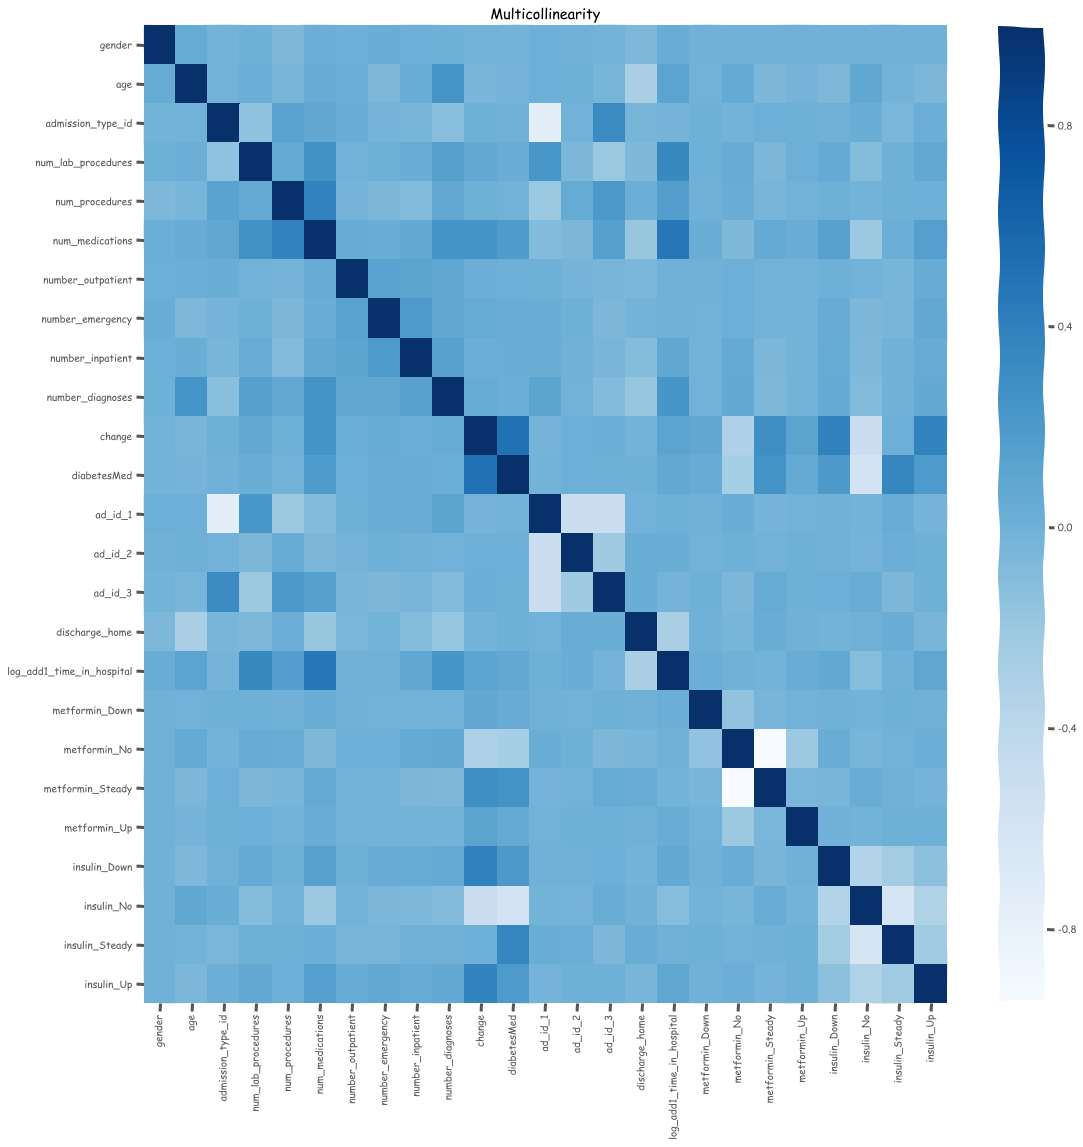

In [5]:
# Evaluating multicollinearity:
corr = X.corr()
fig = plt.figure(figsize=(18,18))
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=False, cmap='Blues', cbar=True)
ax.set_title("Multicollinearity")

In [6]:
sol.head(8)

change              diabetesMed                  0.506360
num_medications     log_add1_time_in_hospital    0.466041
change              insulin_Down                 0.398655
num_procedures      num_medications              0.385761
change              insulin_Up                   0.381739
diabetesMed         insulin_Steady               0.360438
num_lab_procedures  log_add1_time_in_hospital    0.333546
admission_type_id   ad_id_3                      0.322145
dtype: float64

In [7]:
sol.tail(8)

insulin_Down       insulin_No         -0.344783
ad_id_1            ad_id_2            -0.500750
                   ad_id_3            -0.507162
change             insulin_No         -0.513695
diabetesMed        insulin_No         -0.585478
insulin_No         insulin_Steady     -0.615631
admission_type_id  ad_id_1            -0.753122
metformin_No       metformin_Steady   -0.948567
dtype: float64

In [8]:
#X_normalized = preprocessing.normalize(X)
x=X.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_normalized = pd.DataFrame(x_scaled, columns=X.columns)
X_normalized.head()

,gender,age,admission_type_id,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,discharge_home,log_add1_time_in_hospital,metformin_Down,metformin_No,metformin_Steady,metformin_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up
0,1.0,0.000000,0.714286,0.305344,0.000000,0.0000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.111111,0.000000,0.442748,0.000000,0.2125,0.000000,0.0,0.0,0.533333,...,1.0,0.344010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.222222,0.000000,0.076336,0.833333,0.1500,0.047619,0.0,1.0,0.333333,...,1.0,0.201233,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.333333,0.000000,0.328244,0.166667,0.1875,0.000000,0.0,0.0,0.400000,...,1.0,0.201233,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.444444,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.0,0.266667,...,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Text(0.5, 1.0, 'Multicollinearity')

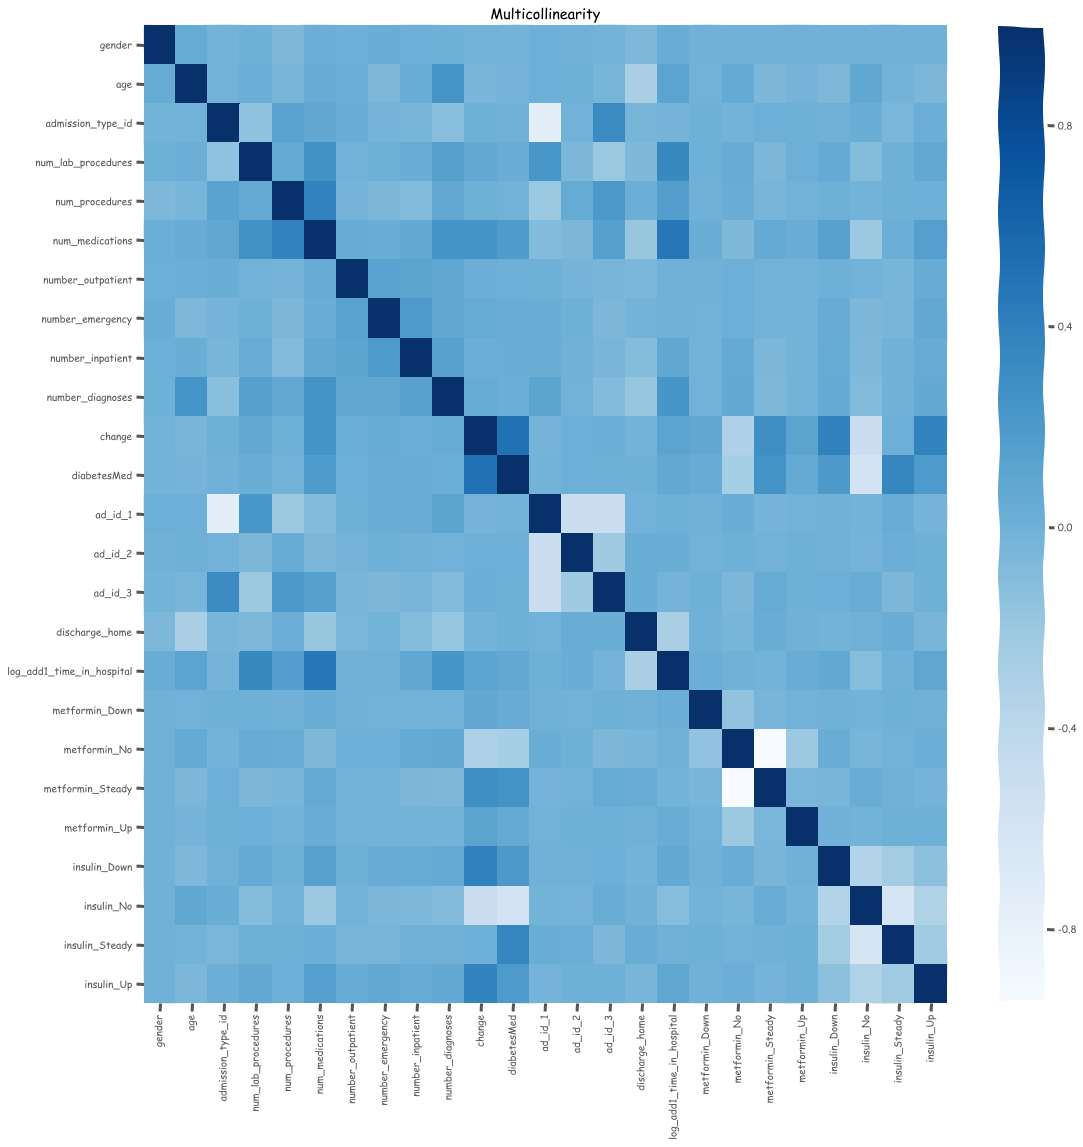

In [9]:
# Evaluating multicollinearity:
corr = X_normalized.corr()
fig = plt.figure(figsize=(18,18))
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=False, cmap='Blues', cbar=True)
ax.set_title("Multicollinearity")

In [10]:
# Should probably remove either the "change" column or look at removing individual medication changes.

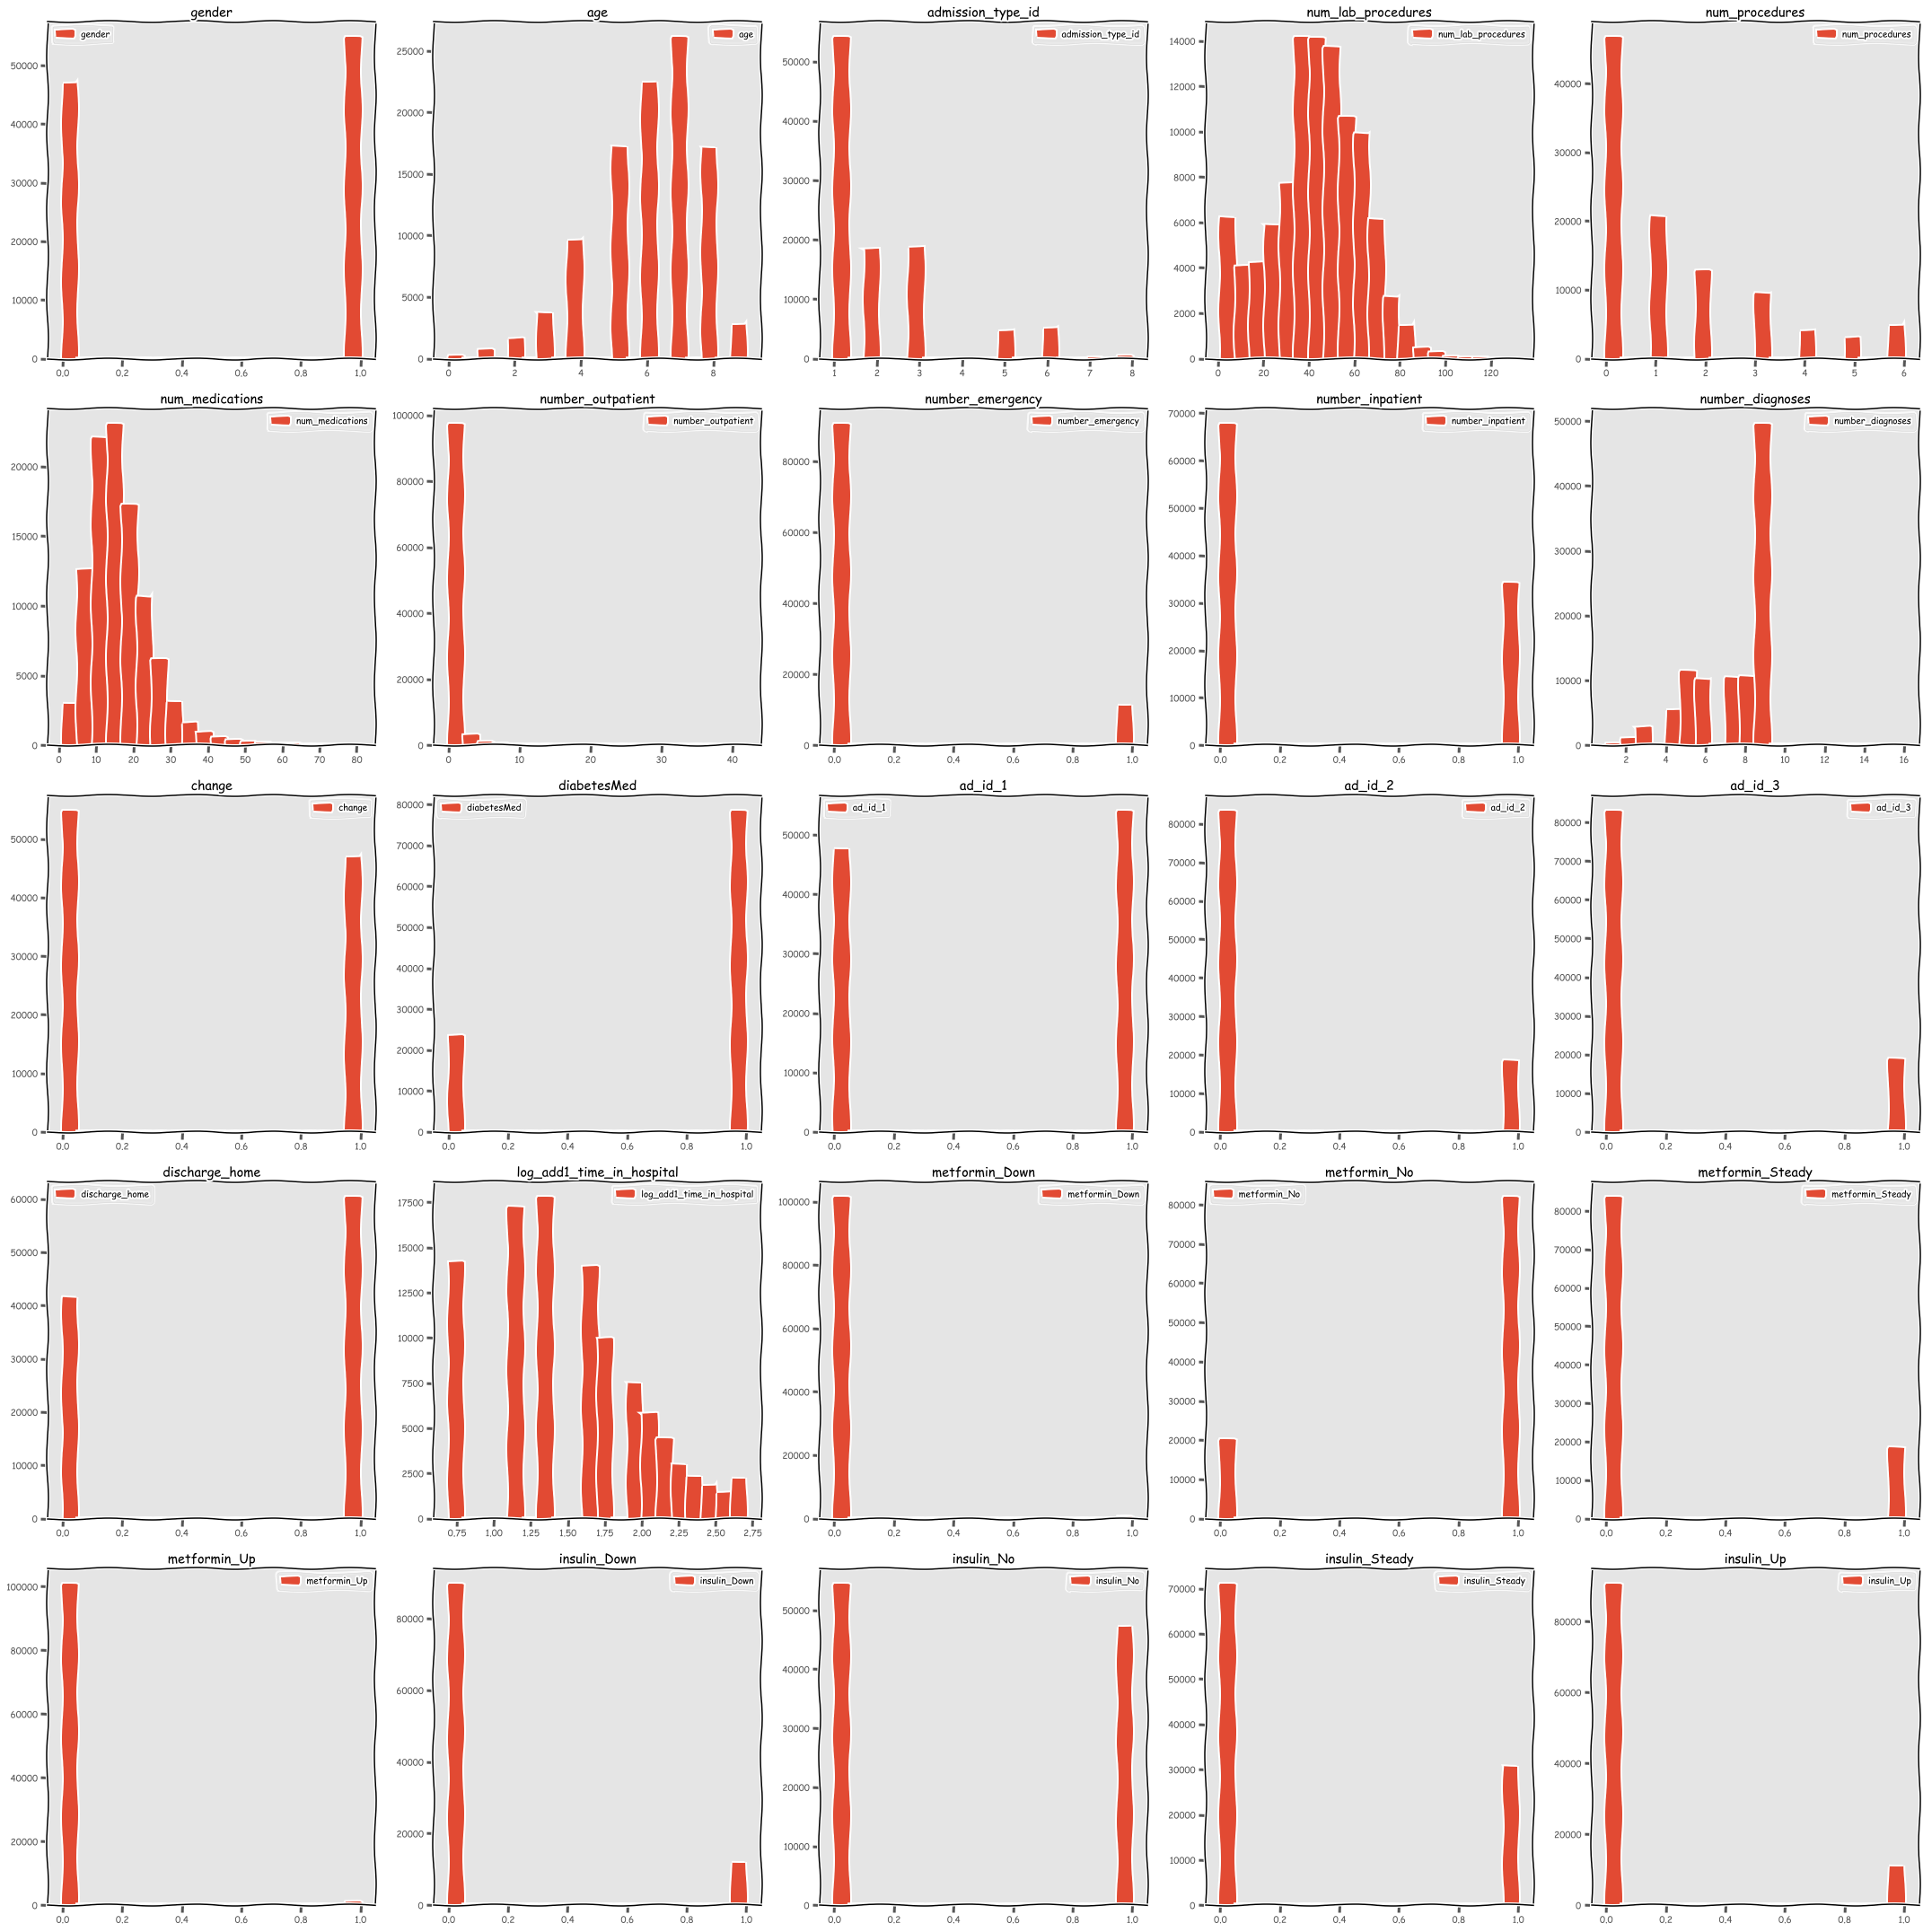

In [11]:
this, that = plt.subplots(5, 5, figsize=(30, 30))
for index, ax in enumerate(that.flatten()):
   column = X.columns[index]
   ax.hist(X[column], bins=20)
   ax.set_title(column)
   ax.legend()
plt.tight_layout(h_pad=1.5)
plt.show()


#and this?

#df_mcl.hist(column=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
#                    'floors', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated'], 
#           bins=25, figsize=(12,12))

In [12]:
'''
this, that = plt.subplots(20, 4, figsize=(50, 25))
for index, ax in enumerate(that.flatten()):
   column = X.columns[index]
   ax.plot(X[column])
   ax.set_title(column)
   ax.legend()
#plt.tight_layout(h_pad=1)
plt.show()
'''

'\nthis, that = plt.subplots(20, 4, figsize=(50, 25))\nfor index, ax in enumerate(that.flatten()):\n   column = X.columns[index]\n   ax.plot(X[column])\n   ax.set_title(column)\n   ax.legend()\n#plt.tight_layout(h_pad=1)\nplt.show()\n'

In [13]:
X.describe()

,gender,age,admission_type_id,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,discharge_home,log_add1_time_in_hospital,metformin_Down,metformin_No,metformin_Steady,metformin_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,0.537602,6.096685,2.024017,43.095909,1.339691,16.021835,0.369368,0.111858,0.335446,7.422649,...,0.591885,1.542969,0.005650,0.803593,0.180272,0.010485,0.120063,0.465592,0.303146,0.111200
std,0.498587,1.594102,1.445414,19.674220,1.705792,8.127589,1.267282,0.315193,0.472148,1.933578,...,0.491487,0.534151,0.074957,0.397282,0.384416,0.101859,0.325037,0.498817,0.459620,0.314381
min,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,1.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,...,0.000000,1.098612,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,6.000000,1.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,...,1.000000,1.609438,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,7.000000,3.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,...,1.000000,1.945910,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,9.000000,8.000000,132.000000,6.000000,81.000000,42.000000,1.000000,1.000000,16.000000,...,1.000000,2.708050,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
'''
fig = plt.figure() # I want to make a gridspec for the above histograms:

#gs1 = gridspec.GridSpecb
#axs = []
#for col,num in enumerate(X.columns, 1):
for col in X.columns:
    #ax = fig.add_subplot(4,4,num)
    #axs.append(fig.add_subplot(gs1[num-1]))
    #axs[-1].plot(kind='hist')
    X[col].hist()
    plt.title(f'Distribution of {col}')
    plt.show()
#plt.tight_layout()
#plt.show()
'''

"\nfig = plt.figure() # I want to make a gridspec for the above histograms:\n\n#gs1 = gridspec.GridSpecb\n#axs = []\n#for col,num in enumerate(X.columns, 1):\nfor col in X.columns:\n    #ax = fig.add_subplot(4,4,num)\n    #axs.append(fig.add_subplot(gs1[num-1]))\n    #axs[-1].plot(kind='hist')\n    X[col].hist()\n    plt.title(f'Distribution of {col}')\n    plt.show()\n#plt.tight_layout()\n#plt.show()\n"

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1200)

In [19]:
print("X_train shape:", np.shape(X_train))
print("y_train shape:", np.shape(y_train))
print("X_test shape:", np.shape(X_test))
print("y_test shape:", np.shape(y_test))

X_train shape: (100563, 25)
y_train shape: (100563, 3)
X_test shape: (1200, 25)
y_test shape: (1200, 3)


## Softmax Regression:

In [20]:
import sklearn
from sklearn import linear_model

In [21]:
'''
def softmax(features):
    
    Calculates softmax for given input array(s)
    :param features:
    :return:
    
    return np.exp(features) / float(sum(np.exp(features)))
'''

'\ndef softmax(features):\n    \n    Calculates softmax for given input array(s)\n    :param features:\n    :return:\n    \n    return np.exp(features) / float(sum(np.exp(features)))\n'

In [22]:
labels_trial = []
for y_label in y_train:
    print(y_label)
    break

<30


In [23]:
labels = y_two.readmitted.unique()
labels_dict = dict(zip(labels, range(len(labels))))
labels_dict

{'NO': 0, '>30': 1, '<30': 2}

In [24]:
y_labels_vec = y_two.readmitted.map(labels_dict)
y_labels_vec.head()

0    0
1    1
2    0
3    0
4    0
Name: readmitted, dtype: int64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels_vec, test_size=1200)

In [26]:
classifier = linear_model.LogisticRegression(C=1e5, solver='newton-cg', multi_class='multinomial')
classifier.fit(X_train, y_train)
pred_labels = classifier.predict(X_train)

In [27]:
classifier.score(X_train, y_train)

0.5694340860952836

In [28]:
classifier.score(X_test, y_test)

0.5758333333333333

In [29]:
coefs = classifier.coef_[0]
top_preds = np.argpartition(coefs, -10)[-10:]
top_preds_sorted = top_preds[np.argsort(coefs[top_preds])]
print(X.columns[top_preds_sorted])

Index(['discharge_home', 'num_procedures', 'metformin_No', 'insulin_Down',
       'metformin_Down', 'insulin_No', 'insulin_Up', 'metformin_Steady',
       'insulin_Steady', 'metformin_Up'],
      dtype='object')


In [30]:
classifier

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [31]:
coefs

array([-2.22634027e-02, -7.19948510e-03, -1.26865568e-01, -1.78864001e-04,
        3.00398029e-02, -1.87924388e-03, -4.82759890e-02, -3.36364424e-01,
       -5.56488546e-01, -4.92611396e-02, -6.87612116e-03, -2.16870340e-01,
       -5.10506421e-01, -3.82698919e-01, -1.81741808e-01,  6.06513017e-03,
       -8.73539470e-02,  3.44122162e-01,  2.98821851e-01,  4.14389295e-01,
        4.99033145e-01,  3.25174456e-01,  3.81001687e-01,  4.67028872e-01,
        3.83161438e-01])

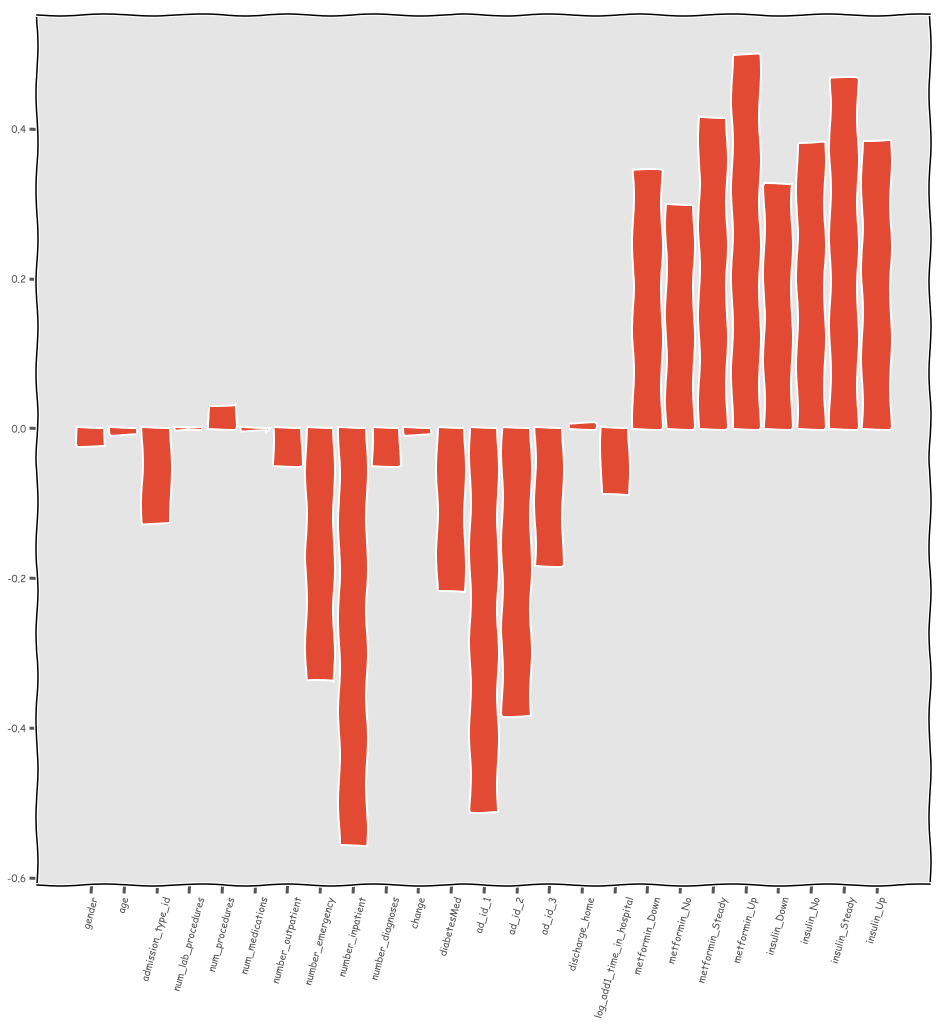

In [32]:
features, scores = X.columns, classifier.coef_[0]

plt.figure(figsize=(16,16))
plt.bar(features, scores)
plt.xticks(rotation=75)
plt.show()

In [33]:
def show_feature_importance(classifier_type, drop=[], X_train=X_train, X_test=X_test, \
                            y_train=y_train, y_test=y_test):
    
    X_train = X_train.drop(drop, axis=1)
    X_test = X_test.drop(drop, axis=1)

    #Choose model type and fit model: 
    classifier = classifier_type()
    classifier.fit(X_train, y_train)
    
    #Predict and evaluate performance: 
    pred_labels = classifier.predict(X_train)
    print(f'Train Performance: {classifier.score(X_train, y_train)}')
    print(f'Test Performance: {classifier.score(X_test, y_test)}')
    
    #Define, plot feature importance: 
    features, scores = X_test.columns, classifier.feature_importances_
    
    plt.figure(figsize=(16,16))
    plt.bar(features, sorted(scores))
    plt.title(f'Visualization: {classifier_type} feature importance')
    plt.xticks(rotation=75)
    plt.show()

Train Performance: 0.5728349392917872
Test Performance: 0.5758333333333333


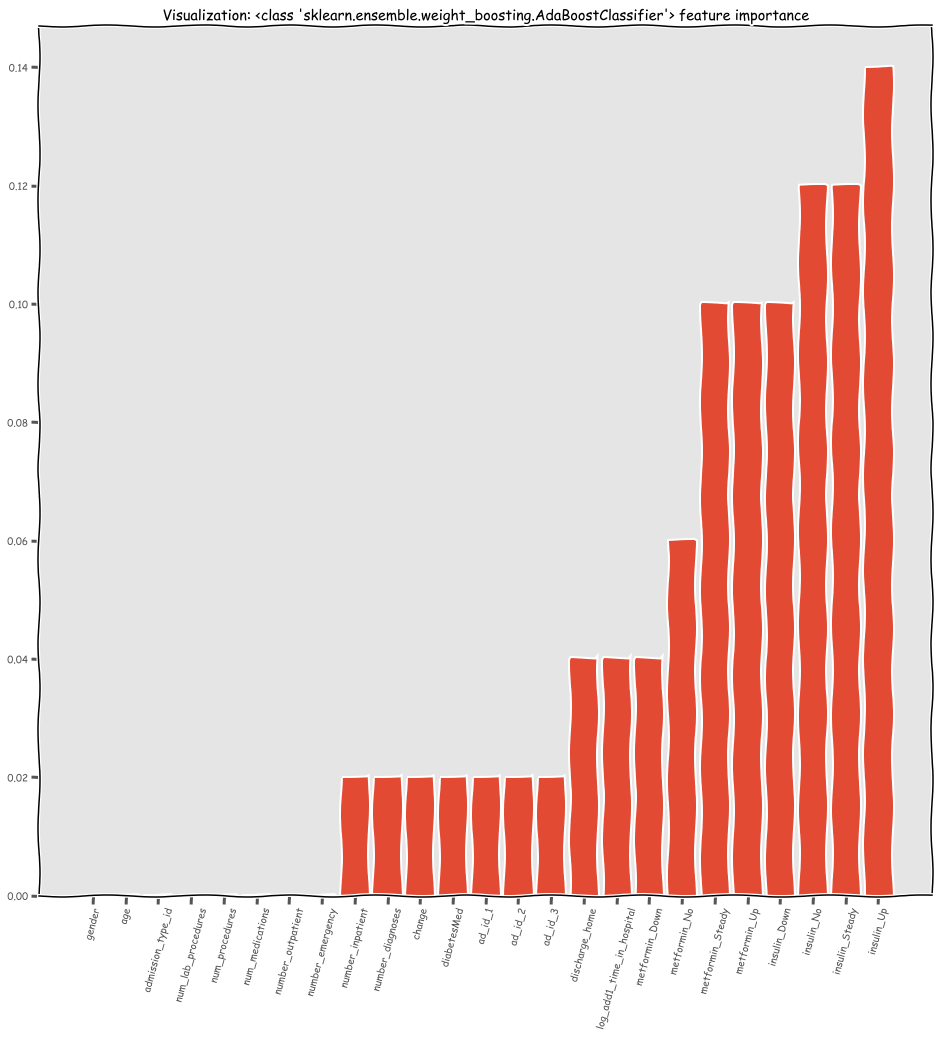

In [34]:
show_feature_importance(classifier_type=AdaBoostClassifier, X_train=X_train, \
                       X_test=X_test, y_train=y_train, y_test=y_test)

Train Performance: 0.5715919373924804
Test Performance: 0.5758333333333333


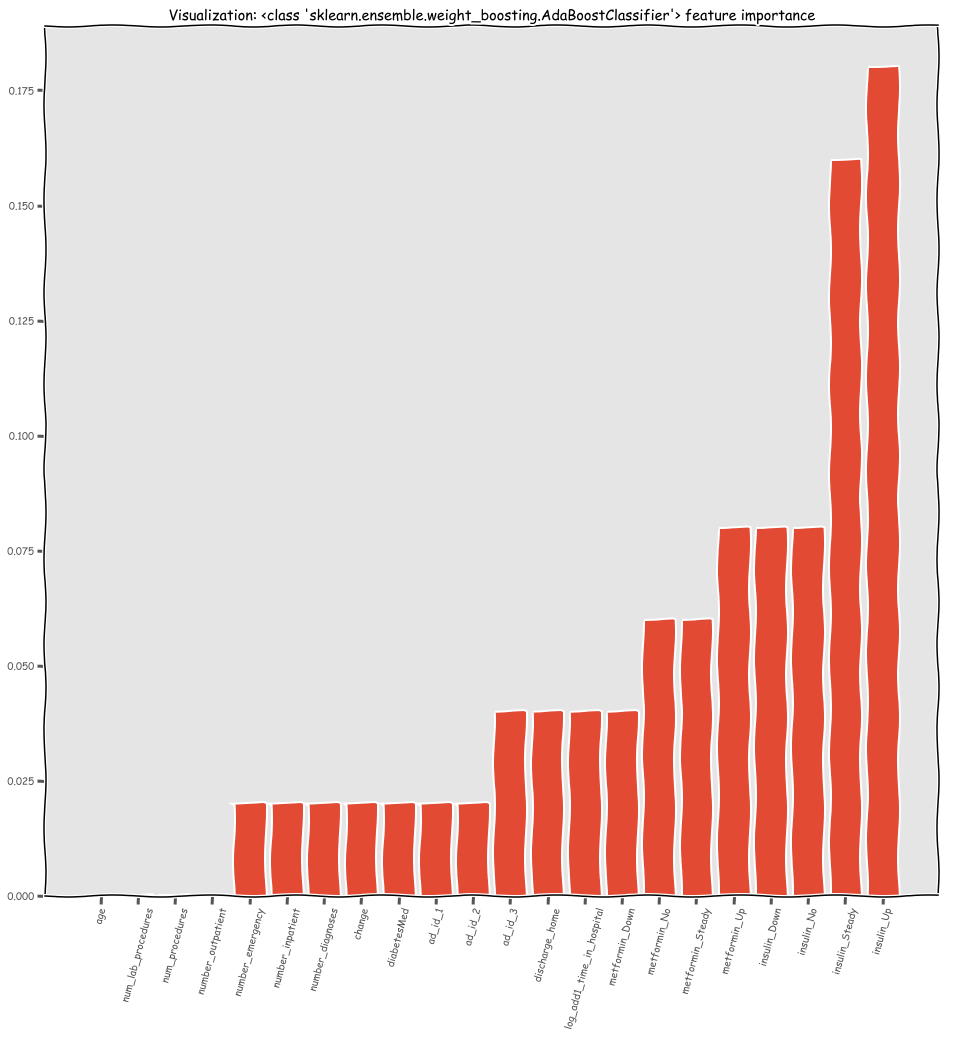

In [35]:
show_feature_importance(classifier_type=AdaBoostClassifier, X_train=X_train, \
                       X_test=X_test, y_train=y_train, y_test=y_test, drop=(['gender', 'admission_type_id', \
                        'num_medications']))

cnf matrix for all models
pipeline - 
    non-parametric
    parametric
Remove features and re-run
Remove data that seems to cause bias and confuse signal
    - fxn
    - x data, y data, list of columns to drop
    - create list of data to train/test on and output

Define a fxn called make_classifier(df= , target= , columns= , columns_drop= , model= (ex:rf,ada, etc)


In [36]:
from sklearn import tree, svm
from sklearn.linear_model import LogisticRegression

In [37]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

## Comparing Machine Learning Techniques:

In [38]:
# Creating a smaller train set to improve runtime:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

In [39]:
#pipe_svm = Pipeline([('clf', svm.SVC(random_state=123))])
        
pipe_tree = Pipeline([('clf', tree.DecisionTreeClassifier(random_state=123))])

pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=123))])

# List of pipelines, List of pipeline names
pipelines = [pipe_tree, pipe_rf]
pipeline_names = ['Decision Tree','Random Forest']

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)

# Compare accuracies
for index, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

Pipeline(memory=None,
     steps=[('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best'))])
Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False))])


/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Decision Tree pipeline test accuracy: 0.450
Random Forest pipeline test accuracy: 0.368


In [40]:
'''
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
            ('clf', svm.SVC(random_state=42))])
            
pipe_dt = Pipeline([('scl', StandardScaler()),
            ('clf', tree.DecisionTreeClassifier(random_state=42))])

# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_svm, pipe_dt]
            
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Support Vector Machine', 2: 'Decision Tree'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

# Compare accuracies
for idx, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.score(X_test, y_test) > best_acc:
        best_acc = val.score(X_test, y_test)
        best_pipe = val
        best_clf = idx
print('Classifier with best accuracy: %s' % pipe_dict[best_clf])
'''

"\npipe_lr = Pipeline([('scl', StandardScaler()),\n            ('clf', LogisticRegression(random_state=42))])\n\npipe_svm = Pipeline([('scl', StandardScaler()),\n            ('clf', svm.SVC(random_state=42))])\n            \npipe_dt = Pipeline([('scl', StandardScaler()),\n            ('clf', tree.DecisionTreeClassifier(random_state=42))])\n\n# List of pipelines for ease of iteration\npipelines = [pipe_lr, pipe_svm, pipe_dt]\n            \n# Dictionary of pipelines and classifier types for ease of reference\npipe_dict = {0: 'Logistic Regression', 1: 'Support Vector Machine', 2: 'Decision Tree'}\n\n# Fit the pipelines\nfor pipe in pipelines:\n    pipe.fit(X_train, y_train)\n\n# Compare accuracies\nfor idx, val in enumerate(pipelines):\n    print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))\n\n# Identify the most accurate model on test data\nbest_acc = 0.0\nbest_clf = 0\nbest_pipe = ''\nfor idx, val in enumerate(pipelines):\n    if val.score(X_test, y_t

In [41]:
# Construct pipeline
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state = 123))])

# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': [50, 70, 90],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 5, 6, 7],  
   'clf__min_samples_leaf':[0.001 ,0.01, 0.05],  
   'clf__min_samples_split':[0.001 ,0.01, 0.05]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50, total=   1.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50, total=   1.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50, total=   1.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=70 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=70, total=   1.7s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=70 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=70, total=   1.7s
[CV] clf__criterion=entropy, clf__max_depth=

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=70, total=   1.7s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90, total=   2.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90, total=   2.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90, total=   2.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=50, total=   1.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=50 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=50, total=   1.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=50 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=50, total=   1.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=70 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=70, total=   1.7s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.01, clf__n_estimators=70, total=   1.9s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.01, clf__n_estimators=70 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.01, clf__n_estimators=70, total=   1.9s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.01, clf__n_estimators=90 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.01, clf__n_estimators=90, total=   2.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.01, clf__n_estimators=90 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.01, clf__n_estimators=90, total=   2.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf_

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.01, clf__n_estimators=90, total=   2.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=50 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=50, total=   1.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=50 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=50, total=   1.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=50 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=50, total=   1.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=70, total=   1.6s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=70 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=70, total=   1.6s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=70 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=70, total=   1.6s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=90 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=90, total=   2.0s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=90, total=   2.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=90 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=90, total=   2.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=50 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=50, total=   1.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=50 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=50, total=   1.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf_

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.001, clf__n_estimators=50, total=   1.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.001, clf__n_estimators=70 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.001, clf__n_estimators=70, total=   1.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.001, clf__n_estimators=70 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.001, clf__n_estimators=70, total=   1.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.001, clf__n_estimators=70 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.001, clf__n_estimators=70, total=   1.7s
[CV] clf__criterion=entropy, clf__max_depth=6, clf_

[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=90, total=   3.2s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=90 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=90, total=   3.2s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=90 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=90, total=   3.1s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.01, clf__n_estimators=50 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.01, clf__n_estimators=50, total=   1.7s
[CV] clf__criterion=entropy, clf__max_depth=7,

[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.01, clf__n_estimators=50, total=   1.4s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.01, clf__n_estimators=50 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.01, clf__n_estimators=50, total=   1.6s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.01, clf__n_estimators=70 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.01, clf__n_estimators=70, total=   2.3s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.01, clf__n_estimators=70 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.01, clf__n_estimators=70, total=   2.3s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=70, total=   1.8s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=90 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=90, total=   2.3s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=90 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=90, total=   2.3s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=90 
[CV]  clf__criterion=entropy, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=90, total=   2.3s
[CV] clf__criterion=entropy, clf__max_depth=7, clf__min_sa

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=50, total=   1.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=50 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=50, total=   1.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=50 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=50, total=   1.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=70 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=70, total=   1.9s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.001,

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=70, total=   1.8s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=90 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=90, total=   2.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=90 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=90, total=   2.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=90 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=90, total=   2.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50, total=   1.5s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50, total=   1.5s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=70 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=70, total=   2.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=70 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=70, total=   2.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90, total=   2.6s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90, total=   2.6s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90, total=   2.6s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.01, clf__n_estimators=50 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.01, clf__min_samples_split=0.01, clf__n_estimators=50, total=   1.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.01, cl

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=50, total=   1.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=70 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=70, total=   1.8s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=70 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=70, total=   1.8s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=70 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=70, total=   1.8s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.001, clf__min_samples_split=0.01, clf__n_estimators=90, total=   3.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.001, clf__min_samples_split=0.01, clf__n_estimators=90 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.001, clf__min_samples_split=0.01, clf__n_estimators=90, total=   2.9s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=50 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=50, total=   1.5s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=50 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.001, clf__min_samples_split=0.05, clf__n_estimators=50, total=   1.5s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.001,

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=70, total=   2.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=70 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=70, total=   2.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=70 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=70, total=   2.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=90 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.01, clf__min_samples_split=0.05, clf__n_estimators=90, total=   2.6s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.01, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=90, total=   2.3s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50, total=   1.8s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50, total=   1.8s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.001, clf__min_samples_split=0.001, clf__n_estimators=50, total=   1.8s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0

[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=70, total=   2.3s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=70 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=70, total=   2.3s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90, total=   2.9s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.01, clf__min_samples_split=0.001, clf__n_estimators=90, total=   2.9s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.01, 

[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=50, total=   1.4s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=50 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=50, total=   1.3s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=50 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=50, total=   1.3s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=70 
[CV]  clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__min_samples_split=0.01, clf__n_estimators=70, total=   1.9s
[CV] clf__criterion=gini, clf__max_depth=7, clf__min_samples_leaf=0.05, clf__mi

[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed: 27.6min finished


Best accuracy: 0.430

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.001, 'clf__n_estimators': 70}


In [51]:
rf_model = RandomForestClassifier(n_estimators=70, criterion='gini', \
                                  min_samples_split=.001, max_depth=4, min_samples_leaf= .05)

rf_model.fit(X_train, y_train)
rf_model.predict(X_train)

rf_model.score(X_train, y_train)
#rf_model.score(X_train, y_train)

#rf_model.score(X_test, y_test)

0.4175814919841649

## Tuning: Batch Size and Number of Epochs for Neural Networks

In [56]:
# Tune Batch Size, Number of Epochs:

# Use scikit-learn to grid search the batch size and epochs
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=25, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
#seed = 123

# create model
model = KerasClassifier(build_fn=create_model, verbose=1)

# define the grid search parameters
batch_size = [64, 128, 256, 512]
epochs = [50, 100, 150, 250]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# summarize results:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/250
71234/71234 [==============================] - 2s 34us/step - loss: 0.7072 - acc: 0.6919
Epoch 2/250
71234/71234 [==============================] - 2s 25us/step - loss: 0.5488 - acc: 0.7166
Epoch 3/250
71234/71234 [==============================] - 2s 23us/step - loss: 0.5445 - acc: 0.7201
Epoch 4/250
71234/71234 [==============================] - 1s 20us/step - loss: 0.5433 - acc: 0.7200
Epoch 5/250
71234/71234 [==============================] - 1s 19us/step - loss: 0.5420 - acc: 0.7216
Epoch 6/250
71234/71234 [==============================] - 1s 18us/step - loss: 0.5417 - acc: 0.7215
Epoch 7/250
71234/71234 [==============================] - 1s 18us/step - loss: 0.5421 - acc: 0.7208
Epoch 8/250
71234/71234 [==============================] - 1s 17us/step - loss: 0.5416 - acc: 0.7212
Epoch 9/250
71234/71234 [==============================] - 1s 16us/step - loss: 0.5412 - acc: 0.7214
Epoch 10/250
71234/71234 [==============================] - 1s 16us/step - loss: 0.5411 - a

71234/71234 [==============================] - 1s 11us/step - loss: 0.5365 - acc: 0.7243: 0s - loss: 0.5363 - acc
Epoch 80/250
71234/71234 [==============================] - 1s 12us/step - loss: 0.5363 - acc: 0.7237: 0s - loss: 0.5370 - acc: 0
Epoch 81/250
71234/71234 [==============================] - 1s 11us/step - loss: 0.5365 - acc: 0.7240: 0s - loss: 0.5367 - acc: 0.723
Epoch 82/250
71234/71234 [==============================] - 1s 11us/step - loss: 0.5362 - acc: 0.7243
Epoch 83/250
71234/71234 [==============================] - 1s 11us/step - loss: 0.5363 - acc: 0.7238
Epoch 84/250
71234/71234 [==============================] - 1s 11us/step - loss: 0.5362 - acc: 0.7241: 0s - loss: 0.5366 - acc: 0.723
Epoch 85/250
71234/71234 [==============================] - 1s 12us/step - loss: 0.5362 - acc: 0.7240
Epoch 86/250
71234/71234 [==============================] - 1s 11us/step - loss: 0.5361 - acc: 0.7240: 0s - loss: 0.5372 - acc: 
Epoch 87/250
71234/71234 [===========================

71234/71234 [==============================] - 1s 13us/step - loss: 0.5340 - acc: 0.7255
Epoch 155/250
71234/71234 [==============================] - 1s 12us/step - loss: 0.5339 - acc: 0.7259
Epoch 156/250
71234/71234 [==============================] - 1s 12us/step - loss: 0.5342 - acc: 0.7256
Epoch 157/250
71234/71234 [==============================] - 1s 13us/step - loss: 0.5342 - acc: 0.7254
Epoch 158/250
71234/71234 [==============================] - 1s 12us/step - loss: 0.5342 - acc: 0.7252
Epoch 159/250
71234/71234 [==============================] - 1s 13us/step - loss: 0.5341 - acc: 0.7255: 0s - loss: 0.5342 
Epoch 160/250
71234/71234 [==============================] - 1s 12us/step - loss: 0.5341 - acc: 0.7250
Epoch 161/250
71234/71234 [==============================] - 1s 12us/step - loss: 0.5340 - acc: 0.7265
Epoch 162/250
71234/71234 [==============================] - ETA: 0s - loss: 0.5341 - acc: 0.7258- ETA: 0s - loss: 0.5347 - acc - 1s 11us/step - loss: 0.5341 - acc: 0.725

71234/71234 [==============================] - 1s 13us/step - loss: 0.5335 - acc: 0.7264
Epoch 227/250
71234/71234 [==============================] - 1s 13us/step - loss: 0.5335 - acc: 0.7262
Epoch 228/250
71234/71234 [==============================] - 1s 13us/step - loss: 0.5336 - acc: 0.7258
Epoch 229/250
71234/71234 [==============================] - 1s 13us/step - loss: 0.5334 - acc: 0.7258
Epoch 230/250
71234/71234 [==============================] - 1s 12us/step - loss: 0.5334 - acc: 0.7262
Epoch 231/250
71234/71234 [==============================] - 1s 13us/step - loss: 0.5336 - acc: 0.7259
Epoch 232/250
71234/71234 [==============================] - 1s 13us/step - loss: 0.5335 - acc: 0.7264
Epoch 233/250
71234/71234 [==============================] - 1s 12us/step - loss: 0.5336 - acc: 0.7266
Epoch 234/250
71234/71234 [==============================] - 1s 13us/step - loss: 0.5334 - acc: 0.7259
Epoch 235/250
71234/71234 [==============================] - 1s 12us/step - loss: 0.533

## Tune Training Optimization Algorithm:

In [60]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
    
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=25, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=250, batch_size=64, verbose=2)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/250
 - 2s - loss: 0.7695 - acc: 0.6879
Epoch 2/250
 - 1s - loss: 0.5477 - acc: 0.7177
Epoch 3/250
 - 1s - loss: 0.5444 - acc: 0.7193
Epoch 4/250
 - 1s - loss: 0.5439 - acc: 0.7203
Epoch 5/250
 - 1s - loss: 0.5438 - acc: 0.7198
Epoch 6/250
 - 1s - loss: 0.5428 - acc: 0.7202
Epoch 7/250
 - 1s - loss: 0.5421 - acc: 0.7209
Epoch 8/250
 - 1s - loss: 0.5420 - acc: 0.7206
Epoch 9/250
 - 1s - loss: 0.5415 - acc: 0.7209
Epoch 10/250
 - 1s - loss: 0.5411 - acc: 0.7217
Epoch 11/250
 - 1s - loss: 0.5404 - acc: 0.7224
Epoch 12/250
 - 1s - loss: 0.5408 - acc: 0.7216
Epoch 13/250
 - 1s - loss: 0.5405 - acc: 0.7216
Epoch 14/250
 - 1s - loss: 0.5399 - acc: 0.7223
Epoch 15/250
 - 1s - loss: 0.5398 - acc: 0.7226
Epoch 16/250
 - 1s - loss: 0.5404 - acc: 0.7218
Epoch 17/250
 - 1s - loss: 0.5402 - acc: 0.7220
Epoch 18/250
 - 1s - loss: 0.5398 - acc: 0.7225
Epoch 19/250
 - 1s - loss: 0.5393 - acc: 0.7224
Epoch 20/250
 - 1s - loss: 0.5388 - acc: 0.7230
Epoch 21/250
 - 1s - loss: 0.5392 - acc: 0.7223
E

Epoch 171/250
 - 1s - loss: 0.5331 - acc: 0.7263
Epoch 172/250
 - 1s - loss: 0.5332 - acc: 0.7262
Epoch 173/250
 - 1s - loss: 0.5330 - acc: 0.7259
Epoch 174/250
 - 1s - loss: 0.5332 - acc: 0.7264
Epoch 175/250
 - 1s - loss: 0.5330 - acc: 0.7265
Epoch 176/250
 - 1s - loss: 0.5332 - acc: 0.7258
Epoch 177/250
 - 1s - loss: 0.5331 - acc: 0.7264
Epoch 178/250
 - 1s - loss: 0.5332 - acc: 0.7263
Epoch 179/250
 - 1s - loss: 0.5332 - acc: 0.7265
Epoch 180/250
 - 1s - loss: 0.5330 - acc: 0.7263
Epoch 181/250
 - 1s - loss: 0.5332 - acc: 0.7262
Epoch 182/250
 - 1s - loss: 0.5330 - acc: 0.7263
Epoch 183/250
 - 1s - loss: 0.5330 - acc: 0.7262
Epoch 184/250
 - 1s - loss: 0.5329 - acc: 0.7268
Epoch 185/250
 - 1s - loss: 0.5330 - acc: 0.7262
Epoch 186/250
 - 1s - loss: 0.5330 - acc: 0.7261
Epoch 187/250
 - 1s - loss: 0.5331 - acc: 0.7262
Epoch 188/250
 - 1s - loss: 0.5330 - acc: 0.7264
Epoch 189/250
 - 1s - loss: 0.5330 - acc: 0.7261
Epoch 190/250
 - 1s - loss: 0.5330 - acc: 0.7266
Epoch 191/250
 - 1s 

## Tune Learning Rate, Momentum:

In [80]:
# create model
# Function to create model, required for KerasClassifier
def create_model(learn_rate=.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=25, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 123
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=64, batch_size=128, verbose=2)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/64
 - 1s - loss: 0.5974 - acc: 0.6693
Epoch 2/64
 - 0s - loss: 0.5698 - acc: 0.6771
Epoch 3/64
 - 0s - loss: 0.5678 - acc: 0.6803
Epoch 4/64
 - 0s - loss: 0.5667 - acc: 0.6830
Epoch 5/64
 - 0s - loss: 0.5658 - acc: 0.6865
Epoch 6/64
 - 0s - loss: 0.5651 - acc: 0.6889
Epoch 7/64
 - 0s - loss: 0.5646 - acc: 0.6914
Epoch 8/64
 - 0s - loss: 0.5643 - acc: 0.6926
Epoch 9/64
 - 0s - loss: 0.5640 - acc: 0.6936
Epoch 10/64
 - 0s - loss: 0.5637 - acc: 0.6943
Epoch 11/64
 - 0s - loss: 0.5635 - acc: 0.6945
Epoch 12/64
 - 0s - loss: 0.5634 - acc: 0.6947
Epoch 13/64
 - 0s - loss: 0.5632 - acc: 0.6948
Epoch 14/64
 - 0s - loss: 0.5631 - acc: 0.6949
Epoch 15/64
 - 0s - loss: 0.5629 - acc: 0.6949
Epoch 16/64
 - 0s - loss: 0.5628 - acc: 0.6949
Epoch 17/64
 - 0s - loss: 0.5627 - acc: 0.6949
Epoch 18/64
 - 0s - loss: 0.5623 - acc: 0.6949
Epoch 19/64
 - 0s - loss: 0.5619 - acc: 0.6949
Epoch 20/64
 - 0s - loss: 0.5618 - acc: 0.6949
Epoch 21/64
 - 0s - loss: 0.5617 - acc: 0.6949
Epoch 22/64
 - 0s - lo

In [79]:
'''
# Copy Paste Code let's see if it works:
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=25, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	optimizer = SGD(lr=learn_rate, momentum=momentum)
	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=128, verbose=2)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
'''

'\n# Copy Paste Code let\'s see if it works:\n# Function to create model, required for KerasClassifier\ndef create_model(learn_rate=0.01, momentum=0):\n\t# create model\n\tmodel = Sequential()\n\tmodel.add(Dense(12, input_dim=25, activation=\'relu\'))\n\tmodel.add(Dense(3, activation=\'softmax\'))\n\t# Compile model\n\toptimizer = SGD(lr=learn_rate, momentum=momentum)\n\tmodel.compile(loss=\'binary_crossentropy\', optimizer=optimizer, metrics=[\'accuracy\'])\n\treturn model\n# fix random seed for reproducibility\nseed = 7\nnp.random.seed(seed)\n\n# create model\nmodel = KerasClassifier(build_fn=create_model, epochs=100, batch_size=128, verbose=2)\n# define the grid search parameters\nlearn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]\nmomentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]\nparam_grid = dict(learn_rate=learn_rate, momentum=momentum)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)\ngrid_result = grid.fit(X_train, y_train)\n# summarize results\nprint("Best: %f using %s"

## Tune Weight Initialization:

In [69]:
# Function to create model, required for KerasClassifier
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=25, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(3, kernel_initializer=init_mode, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 123
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=64, verbose=2)

# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/100
 - 2s - loss: 0.5525 - acc: 0.7100
Epoch 2/100
 - 1s - loss: 0.5412 - acc: 0.7212
Epoch 3/100
 - 1s - loss: 0.5394 - acc: 0.7223
Epoch 4/100
 - 1s - loss: 0.5384 - acc: 0.7226
Epoch 5/100
 - 1s - loss: 0.5377 - acc: 0.7234
Epoch 6/100
 - 1s - loss: 0.5374 - acc: 0.7230
Epoch 7/100
 - 1s - loss: 0.5367 - acc: 0.7237
Epoch 8/100
 - 1s - loss: 0.5368 - acc: 0.7239
Epoch 9/100
 - 1s - loss: 0.5365 - acc: 0.7238
Epoch 10/100
 - 1s - loss: 0.5369 - acc: 0.7237
Epoch 11/100
 - 1s - loss: 0.5366 - acc: 0.7241
Epoch 12/100
 - 1s - loss: 0.5361 - acc: 0.7245
Epoch 13/100
 - 1s - loss: 0.5361 - acc: 0.7241
Epoch 14/100
 - 1s - loss: 0.5361 - acc: 0.7245
Epoch 15/100
 - 1s - loss: 0.5362 - acc: 0.7249
Epoch 16/100
 - 1s - loss: 0.5359 - acc: 0.7247
Epoch 17/100
 - 1s - loss: 0.5360 - acc: 0.7242
Epoch 18/100
 - 1s - loss: 0.5359 - acc: 0.7250
Epoch 19/100
 - 1s - loss: 0.5359 - acc: 0.7250
Epoch 20/100
 - 1s - loss: 0.5357 - acc: 0.7247
Epoch 21/100
 - 1s - loss: 0.5359 - acc: 0.7251
E

## Tune Droprate Regularization:

In [81]:
# Use scikit-learn to grid search the dropout rate
from keras.constraints import maxnorm

# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.0, weight_constraint=0):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=25, kernel_initializer='uniform', activation='linear', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, kernel_initializer='uniform', activation='softmax'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 123
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=128, verbose=2)

# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/100
 - 2s - loss: 0.5570 - acc: 0.7036
Epoch 2/100
 - 1s - loss: 0.5443 - acc: 0.7192
Epoch 3/100
 - 1s - loss: 0.5425 - acc: 0.7208
Epoch 4/100
 - 1s - loss: 0.5418 - acc: 0.7208
Epoch 5/100
 - 1s - loss: 0.5412 - acc: 0.7210
Epoch 6/100
 - 1s - loss: 0.5411 - acc: 0.7212
Epoch 7/100
 - 1s - loss: 0.5407 - acc: 0.7208
Epoch 8/100
 - 1s - loss: 0.5408 - acc: 0.7218
Epoch 9/100
 - 1s - loss: 0.5407 - acc: 0.7214
Epoch 10/100
 - 1s - loss: 0.5407 - acc: 0.7215
Epoch 11/100
 - 1s - loss: 0.5404 - acc: 0.7216
Epoch 12/100
 - 1s - loss: 0.5404 - acc: 0.7215
Epoch 13/100
 - 1s - loss: 0.5403 - acc: 0.7211
Epoch 14/100
 - 1s - loss: 0.5407 - acc: 0.7215
Epoch 15/100
 - 1s - loss: 0.5407 - acc: 0.7214
Epoch 16/100
 - 1s - loss: 0.5402 - acc: 0.7219
Epoch 17/100
 - 1s - loss: 0.5404 - acc: 0.7216
Epoch 18/100
 - 1s - loss: 0.5404 - acc: 0.7219
Epoch 19/100
 - 1s - loss: 0.5404 - acc: 0.7215
Epoch 20/100
 - 1s - loss: 0.5404 - acc: 0.7219
Epoch 21/100
 - 1s - loss: 0.5407 - acc: 0.7209
E

In [167]:
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 12, kernel_initializer = 'normal', 
        activation = 'relu', input_dim = 25))
    #classifier.add(Dense(units = 6, kernel_initializer = 'normal', 
    #    activation = 'relu'))
    classifier.add(Dense(units = 3, kernel_initializer = 'normal', 
        activation = 'softmax'))
    classifier.compile(optimizer = optimizer, loss = 
        'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [64, 128],
          'epochs': [25, 50],
          'optimizer': ['adam']}


grid_search = GridSearchCV(estimator = classifier,
                       param_grid = parameters,
                       scoring = 'accuracy',
                       cv = 10)
grid_search = grid_search.fit(X_train, y_train)    

'''
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
'''

Epoch 1/25
64110/64110 [==============================] - 2s 37us/step - loss: 0.5528 - acc: 0.7107
Epoch 2/25
64110/64110 [==============================] - 1s 21us/step - loss: 0.5420 - acc: 0.7209
Epoch 3/25
64110/64110 [==============================] - 1s 20us/step - loss: 0.5400 - acc: 0.7218
Epoch 4/25
64110/64110 [==============================] - 1s 21us/step - loss: 0.5387 - acc: 0.7227
Epoch 5/25
64110/64110 [==============================] - 1s 21us/step - loss: 0.5380 - acc: 0.7227
Epoch 6/25
64110/64110 [==============================] - 1s 20us/step - loss: 0.5371 - acc: 0.7238
Epoch 7/25
64110/64110 [==============================] - 1s 21us/step - loss: 0.5369 - acc: 0.7237
Epoch 8/25
64110/64110 [==============================] - 1s 23us/step - loss: 0.5371 - acc: 0.7234
Epoch 9/25
64110/64110 [==============================] - 1s 20us/step - loss: 0.5367 - acc: 0.7233
Epoch 10/25
64110/64110 [==============================] - 1s 21us/step - loss: 0.5363 - acc: 0.7246

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [177]:
#Predict and evaluate performance: 
pred_labels = classifier.predict(X_train)
print(f'Train Performance: {classifier.score(X_train, y_train)}')
print(f'Test Performance: {classifier.score(X_test, y_test)}')
    
#Define, plot feature importance: 
features, scores = X_test.columns, classifier.coef_[0]
    
plt.figure(figsize=(16,16))
plt.bar(features, sorted(scores))
plt.title(f'Visualization: {classifier_type} feature importance')
plt.xticks(rotation=75)
plt.show()

NotFittedError: This AdaBoostClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [111]:
# Function to create model, required for KerasClassifier
'''
def create_model(learn_rate=.001, momentum=.9, weight_constraint=2):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=25, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
    '''

"\ndef create_model(learn_rate=.001, momentum=.9, weight_constraint=2):\n    # create model\n    model = Sequential()\n    model.add(Dense(12, input_dim=25, activation='relu'))\n    model.add(Dense(3, activation='softmax'))\n    \n    # Compile model\n    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])\n    \n    return model\n    "

In [145]:
''' fix random seed for reproducibility
seed = 123
np.random.seed(seed)

model = Sequential()
model.add(Dense(12, input_dim=25, activation='relu', kernel_constraint=maxnorm(2)))
model.add(Dense(3, activation='softmax'))
    
adam = optimizers.Adam(lr=0.001)

# Compile model
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=64, epochs=256, verbose=2)
'''

" fix random seed for reproducibility\nseed = 123\nnp.random.seed(seed)\n\nmodel = Sequential()\nmodel.add(Dense(12, input_dim=25, activation='relu', kernel_constraint=maxnorm(2)))\nmodel.add(Dense(3, activation='softmax'))\n    \nadam = optimizers.Adam(lr=0.001)\n\n# Compile model\nmodel.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])\n\nhistory = model.fit(X_train, y_train, batch_size=64, epochs=256, verbose=2)\n"

In [185]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

In [194]:
def create_model(dropout_rate=0.0, weight_constraint=2):
    adam = optimizers.Adam(lr=0.001)
    
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=25, activation='linear', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 123
np.random.seed(seed)

# create model
classifier = KerasClassifier(build_fn=create_model, epochs=50, batch_size=128, verbose=2)

classifier.fit(X_train, y_train)

perm = PermutationImportance(classifier, random_state=123).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Epoch 1/50
 - 2s - loss: 1.1978 - acc: 0.6598
Epoch 2/50
 - 1s - loss: 0.5534 - acc: 0.7121
Epoch 3/50
 - 1s - loss: 0.5474 - acc: 0.7177
Epoch 4/50
 - 1s - loss: 0.5453 - acc: 0.7186
Epoch 5/50
 - 1s - loss: 0.5434 - acc: 0.7202
Epoch 6/50
 - 1s - loss: 0.5434 - acc: 0.7201
Epoch 7/50
 - 1s - loss: 0.5424 - acc: 0.7201
Epoch 8/50
 - 1s - loss: 0.5431 - acc: 0.7193
Epoch 9/50
 - 1s - loss: 0.5428 - acc: 0.7200
Epoch 10/50
 - 1s - loss: 0.5437 - acc: 0.7192
Epoch 11/50
 - 1s - loss: 0.5424 - acc: 0.7206
Epoch 12/50
 - 1s - loss: 0.5421 - acc: 0.7205
Epoch 13/50
 - 1s - loss: 0.5423 - acc: 0.7210
Epoch 14/50
 - 1s - loss: 0.5424 - acc: 0.7210
Epoch 15/50
 - 1s - loss: 0.5427 - acc: 0.7204
Epoch 16/50
 - 1s - loss: 0.5419 - acc: 0.7205
Epoch 17/50
 - 1s - loss: 0.5426 - acc: 0.7197
Epoch 18/50
 - 1s - loss: 0.5424 - acc: 0.7202
Epoch 19/50
 - 1s - loss: 0.5427 - acc: 0.7196
Epoch 20/50
 - 1s - loss: 0.5422 - acc: 0.7205
Epoch 21/50
 - 1s - loss: 0.5431 - acc: 0.7194
Epoch 22/50
 - 1s - lo

Weight,Feature
0.0202 ± 0.0014,number_inpatient
0.0026 ± 0.0006,insulin_Steady
0.0020 ± 0.0003,number_emergency
0.0020 ± 0.0002,metformin_Steady
0.0016 ± 0.0004,insulin_No
0.0012 ± 0.0005,number_diagnoses
0.0011 ± 0.0004,ad_id_3
0.0011 ± 0.0003,diabetesMed
0.0009 ± 0.0003,ad_id_2
0.0009 ± 0.0004,ad_id_1


In [204]:
classifier.score(X_train, y_train)

0.7184864928959548

In [205]:
classifier.score(X_test, y_test)

0.7139113693311652

In [206]:
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

In [ ]:
#Train
model.fit_generator(train_generator,
                    steps_per_epoch=num_of_train_samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=num_of_test_samples // batch_size)

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [215]:
display(y_train.head(10))
display(y_test.head(10))
display(y_two.head(10))

,<30,>30,NO
63121,0,1,0
74490,0,1,0
59619,0,1,0
51501,0,0,1
89015,0,0,1
42423,0,1,0
60638,0,1,0
61145,0,1,0
84289,0,0,1
98086,1,0,0


,<30,>30,NO
30821,1,0,0
45746,0,1,0
1177,0,0,1
37603,0,1,0
83875,0,1,0
1650,0,1,0
28560,0,0,1
77156,0,0,1
12824,0,1,0
90011,1,0,0


,readmitted
0,NO
1,>30
2,NO
3,NO
4,NO
5,>30
6,NO
7,>30
8,NO
9,NO


In [221]:
display(y_train[:5])
display(y_hat_train[:20])

,<30,>30,NO
63121,0,1,0
74490,0,1,0
59619,0,1,0
51501,0,0,1
89015,0,0,1


array([1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2])

In [225]:
cnf_matrix = confusion_matrix(y_true=y_train, y_pred=y_hat_train, labels=[0, "<30", ">30"])
print('Confusion Matrix:\n', cnf_matrix)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [223]:
cnf_matrix = confusion_matrix(y_true=y_train.NO, y_pred=y_hat_train)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[    0 12129 20468]
 [    0  7062 31575]
 [    0     0     0]]


In [ ]:
cnf

In [142]:
features, scores = X_test.columns, 
    
plt.figure(figsize=(16,16))
plt.bar(features, sorted(scores))
plt.title(f'Visualization: {classifier_type} feature importance')
plt.xticks(rotation=75)
plt.show()

AttributeError: 'Sequential' object has no attribute 'scores'

In [135]:
''' fix random seed for reproducibility
seed = 123
np.random.seed(seed)

# create model
model = (build_fn=create_model, epochs=256, batch_size=64, verbose=2)
model.fit(X_train, y_train)
'''

' fix random seed for reproducibility\nseed = 123\nnp.random.seed(seed)\n\n# create model\nmodel = (build_fn=create_model, epochs=256, batch_size=64, verbose=2)\nmodel.fit(X_train, y_train)\n'

In [168]:
#Predict and evaluate performance: 
pred_labels = model.predict(X_train)
print(f'Train Performance: {model.evaluate(X_train, y_train)}')
print(f'Test Performance: {model.evaluate(X_test, y_test)}')
    
#Define, plot feature importance: 
features, scores = X_test.columns, model.features_importance_
    
plt.figure(figsize=(16,16))
plt.bar(features, sorted(scores))
plt.title(f'Visualization: {classifier_type} feature importance')
plt.xticks(rotation=75)
plt.show()

AttributeError: 'KerasClassifier' object has no attribute 'evaluate'

In [ ]:
model_1layer = models.Sequential()
model_1layer.add(layers.Dense(64, input_shape=(25,), activation='relu', \
                       kernel_regularizer=regularizers.l2(.005)))
model_1layer.add(layers.Dense(3, activation='softmax'))

model_1layer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_1layer.fit(X_train, y_train, epochs=128, batch_size=32)

## Model 1:
- 
- l2 reg
- 

In [82]:
model_l2 = models.Sequential()
model_l2.add(layers.Dense(64, input_shape=(25,), activation='relu', \
                       kernel_regularizer=regularizers.l2(.005)))
model_l2.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(.005)))
#model.add(layers.Dense(128, activation='relu', ))
model_l2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_l2.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_l2.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(.005)))
#model_l2.add(layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_l2.add(layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_l2.add(layers.Dense(3, activation='softmax'))

model_l2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
start_time = time.time()
history = model_l2.fit(X_train, y_train, epochs=128, batch_size=32)
elapsed_time = time.time() - start_time

Epoch 1/128
71234/71234 [==============================] - 3s 45us/step - loss: 1.0739 - acc: 0.5422
Epoch 2/128
71234/71234 [==============================] - 3s 36us/step - loss: 0.9522 - acc: 0.5424
Epoch 3/128
71234/71234 [==============================] - 3s 36us/step - loss: 0.9452 - acc: 0.5424
Epoch 4/128
71234/71234 [==============================] - 3s 36us/step - loss: 0.9447 - acc: 0.5424
Epoch 5/128
71234/71234 [==============================] - 3s 36us/step - loss: 0.9447 - acc: 0.5424
Epoch 6/128
71234/71234 [==============================] - 3s 36us/step - loss: 0.9446 - acc: 0.5424
Epoch 7/128
71234/71234 [==============================] - 3s 35us/step - loss: 0.9447 - acc: 0.5424
Epoch 8/128
71234/71234 [==============================] - 2s 35us/step - loss: 0.9447 - acc: 0.5424
Epoch 9/128
71234/71234 [==============================] - 3s 36us/step - loss: 0.9446 - acc: 0.5424
Epoch 10/128
71234/71234 [==============================] - 3s 35us/step - loss: 0.9446 - a

71234/71234 [==============================] - 3s 38us/step - loss: 0.9446 - acc: 0.5424
Epoch 82/128
71234/71234 [==============================] - 3s 38us/step - loss: 0.9446 - acc: 0.5424
Epoch 83/128
71234/71234 [==============================] - 3s 38us/step - loss: 0.9446 - acc: 0.5424
Epoch 84/128
71234/71234 [==============================] - 3s 39us/step - loss: 0.9446 - acc: 0.5424
Epoch 85/128
71234/71234 [==============================] - 3s 39us/step - loss: 0.9445 - acc: 0.5424
Epoch 86/128
71234/71234 [==============================] - 3s 39us/step - loss: 0.9446 - acc: 0.5424
Epoch 87/128
71234/71234 [==============================] - 3s 40us/step - loss: 0.9446 - acc: 0.5424
Epoch 88/128
71234/71234 [==============================] - 3s 43us/step - loss: 0.9446 - acc: 0.5424
Epoch 89/128
71234/71234 [==============================] - 3s 41us/step - loss: 0.9446 - acc: 0.5424
Epoch 90/128
71234/71234 [==============================] - 3s 40us/step - loss: 0.9446 - acc: 

In [84]:
elapsed_time

358.0932331085205

In [85]:
model_l2.evaluate(X_train, y_train)

71234/71234 [==============================] - 1s 16us/step


[0.9444602063648905, 0.5423954853019626]

In [86]:
model_l2.evaluate(X_test, y_test)

30529/30529 [==============================] - 0s 14us/step


[0.9471826882440305, 0.5314291329555505]

Model: Testing dropping

In [ ]:
model_drop = models.Sequential()
#model_drop.add(Dropout(.3, input_shape=(142,)))
model_drop.add(layers.Dense(128, input_shape=(25,), activation='relu', \
                       kernel_regularizer=regularizers.l2(.005)))
model_drop.add(Dropout(.25))
model_drop.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_drop.add(Dropout(.25))
#model.add(layers.Dense(128, activation='relu', ))
model_drop.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_drop.add(Dropout(.25))
model_drop.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_drop.add(Dropout(.25))
model_drop.add(layers.Dense(3, activation='softmax'))

model_drop.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start_time = time.time()
history = model_drop.fit(X_train, y_train, epochs=256, batch_size=128)
elapsed_time = time.time() - start_time
elapsed_time

In [ ]:
# Trying out LRD:

In [ ]:
np.random.seed(123)

adam = optimizers.Adam(lr=0.03, decay=0.0001)

model_lrd = models.Sequential()
model_lrd.add(layers.Dense(64, input_shape=(25,), activation='relu', \
                       kernel_regularizer=regularizers.l2(.005)))
model_lrd.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.005)))
#model.add(layers.Dense(128, activation='relu', ))
model_lrd.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_lrd.add(layers.Dense(3, activation='softmax'))

model_lrd.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start_time = time.time()
history = model_lrd.fit(X_train, y_train, epochs=256, batch_size=32)
elapsed_time = time.time() - start_time

In [ ]:
#model_lrd.predict(X_test, y_test)

model_lrd.evaluate(X_train, y_train)
model_lrd.evaluate(X_test, y_test)

Model:

In [ ]:
np.random.seed(123)

adam = optimizers.Adam(lr=0.03, decay=0.0001)

model_a = models.Sequential()
model_a.add(layers.Dense(64, input_shape=(25,), activation='relu', \
                       kernel_regularizer=regularizers.l1(.005)))
model_a.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(.005)))
#model.add(layers.Dense(128, activation='relu', ))
model_a.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(.005)))
model_a.add(layers.Dense(3, activation='softmax'))

model_a.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start_time = time.time()
history = model_a.fit(X_train, y_train, epochs=256, batch_size=32)
elapsed_time = time.time() - start_time

In [ ]:
start_time = time.time()
history = model_l2.fit(X_train, y_train, epochs=64, batch_size=256)
elapsed_time = time.time() - start_time

In [ ]:
model_l2.evaluate(X_test, y_test)

In [ ]:
model_l2.evaluate(X_train, y_train)

Model:

In [ ]:
model_tester = models.Sequential()
#model_drop.add(Dropout(.3, input_shape=(142,)))
model_tester.add(layers.Dense(64, input_shape=(25,), activation='relu', \
                       kernel_regularizer=regularizers.l2(.005)))
model_tester.add(Dropout(.2))
model_tester.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_tester.add(Dropout(.2))
model_tester.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_tester.add(Dropout(.2))
model_tester.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_tester.add(Dropout(.2))
model_tester.add(layers.Dense(3, activation='softmax'))

model_tester.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start_time = time.time()
history = model_tester.fit(X_train, y_train, epochs=256, batch_size=32)
elapsed_time = time.time() - start_time

In [ ]:
elapsed_time

In [ ]:
'''
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
'''

Model:

In [ ]:
model_l1 = 

Model:
- Multiplayer Perceptron for multi-class softmax classification:

In [ ]:
model = models.Sequential()

model.add(Dense(64, activation='relu', input_dim=25))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=128,
          batch_size=32)
score = model.evaluate(X_test, y_test, batch_size=128)

In [ ]:
score

Adam - dropout:

In [ ]:
model = models.Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
model.add(Dense(64, activation='relu', input_dim=25))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

adam = keras.optimizers.Adam(lr=0.001, decay=1e-6, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=128,
          batch_size=32)
score = model.evaluate(X_test, y_test, batch_size=128)

In [ ]:
score

Nadam - dropout

In [ ]:
model = models.Sequential()

model.add(Dense(64, activation='relu', input_dim=25))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=128,
          batch_size=32)
score = model.evaluate(X_test, y_test, batch_size=128)

In [ ]:
plt.clf()

#####  Make these into functions for plotting:
Training/Val Loss:
```
Training/Validation Loss:

plt.clf()

import matplotlib.pyplot as plt
loss_values = model_val_dict['loss']
val_loss_values = model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
```
Training/Val Accuracy:
```
Training/Val Accuracy:
plt.clf()

acc_values = model_val_dict['acc'] 
val_acc_values = model_val_dict['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
```

Kfolds+grapher
```
Function to evaluate a model object using K folds cross validation.
def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    colors = sns.color_palette('Set2')
    
    validation_scores = []
    kf = KFold(n_splits=10, shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        row = i//5
        col = i%5
        X_train, X_val = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_val = labels_train.iloc[train_index], labels_train.iloc[test_index]
        
        model = model_obj
        hist = model.fit(X_train, y_train, batch_size=32, epochs=n_epochs, \
                         verbose=0, validation_data=(X_val, y_val))
        
        validation_score = model.evaluate(X_val, y_val)
        validation_scores.append(validation_score)
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])

        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
    
    # Graph Formatting:
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.legend(bbox_to_anchor=(1,1))
    
    # General Overview:
    validation_score = np.average(validation_scores)
    print('Mean Validation Score:', validation_score)
    print('Standard Deviation of Validation Scores:', np.std(validation_scores))
    return validation_score
    ```